In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../'

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
timestr = '20201021'

### Building matrix for logistic regression

In [20]:
%ls -ltrh /tmp/2*

-rw-r--r--  1 laurentperrinet  wheel    67M Nov  5 15:00 /tmp/20201021_hots_event0_o-sub.p
-rw-r--r--  1 laurentperrinet  wheel   187M Nov  5 15:24 /tmp/20201021_hots_event0_o.p
-rw-r--r--  1 laurentperrinet  wheel   351M Nov  5 15:26 /tmp/20201021_hots_vectorzLR_subsample_X.npy
-rw-r--r--  1 laurentperrinet  wheel    78K Nov  5 15:26 /tmp/20201021_hots_vectorzLR_subsample_y.npy
-rw-r--r--  1 laurentperrinet  wheel   2.8G Nov  5 15:28 /tmp/20201021_hots_vectorzLR-full_X.npy
-rw-r--r--  1 laurentperrinet  wheel   161K Nov  5 15:28 /tmp/20201021_hots_vectorzLR-full_y.npy


In [4]:
%rm /tmp/20201021_hots_vectorzLR_subsample_*npy

In [5]:
c_int = lambda n, d : ((n - 1) // d) + 1

In [6]:
np.arange(0, 34)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [7]:
np.ceil(34/4)

9.0

In [8]:
np.arange(0, 34)//4

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8])

In [9]:
c_int(34, 4)

9

In [10]:
#fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_vectorzLR.pkl'
fname = '/tmp/'+timestr+'_hots_vectorzLR_subsample'

if not os.path.isfile(fname + '_X.npy'):
    
    import pickle
    from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
    from HOTS.Event import Event, SimpleAlphabet, LoadNMNIST
    from HOTS.STS import STS
    from HOTS.Layer import ClusteringLayer
    from HOTS.ToolsMonitor import (
        DisplayImage,
        DisplaySurface3D,
        DisplaySurface2D,
        DisplayConvergence,
    )
    from HOTS.Tools import SaveObject, LoadObject
    from HOTS.Network import Network
    from HOTS.Event import conv2eve

    tau = 9e-4 # -> tau=1ms, si on prend 10 ms on est à 1s pour la dernière couche et les vidéos font 0.3s en moyenne
    R = 2
    filthr = 2
    nbkNN = 3
    algo = 'lagorce'
    decay = 'exponential'
    hom = True
    krnlinit = 'rdn'
    nb_cluster = [4, 8, 16]
    ImageSize = (34, 34)
    DataPath = 'Data/testsetnmnist.p'

    NbClusteringData = 15
    NbTrainingData = 40
    NbTestingData = 40
    
    NbClusteringData = 150
    NbTrainingData = 500
    NbTestingData = 50

    #timestr = time.strftime("%Y%m%d")
    hom = False

    if hom==True:
        fname_model = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
    else:
        fname_model = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
    print(fname_model)

    _1ofich = False
    event_tr, event_te, event_cl, label_tr, label_te = LoadNMNIST(
    NbTrainingData, NbTestingData, NbClusteringData, OneOfEach=_1ofich, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)

    L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
    L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
    L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
    Net = Network([L1, L2, L3])    
    
    if not os.path.isfile(fname_model):
        ClusterLayer, event_output = Net.TrainCluster(
                event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
            )
        SaveObject(ClusterLayer, fname_model)
    else: 
        ClusterLayer, Classif0 = LoadObject(fname_model)

    fname_event0_o = '/tmp/'+timestr+'_hots_event0_o-sub.p'
    if not os.path.isfile(fname_event0_o):            
        print('run the events through the network')
        homrun = False
        event0_o_tr2 = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        event0_o_te2 = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)
        SaveObject([event0_o_tr2, event0_o_te2], fname_event0_o)
    else: 
        event0_o_tr2, event0_o_te2 = LoadObject(fname_event0_o)
    
    # gather data
    n_events = event0_o_tr2.time.shape[0]
    tau_cla = .300 # characteristic time of a digit 
    sample_events = 200
    sample_space = 2
    
    data = np.zeros((c_int(ImageSize[0], sample_space), c_int(ImageSize[1], sample_space), len(event0_o_tr2.ListPolarities))) #tmp data
    data_len = len(data.ravel()) # ImageSize[0]//sample_space*ImageSize[1]//sample_space*len(event0_o_tr2.ListPolarities)
    X = np.zeros((c_int(n_events, sample_events), data_len))
    y = np.zeros((c_int(n_events, sample_events), ))
    
    t_absolute = 0
    t_old = 0
    i_label_tr = 0
    for i in range(1, n_events):
        if i == event0_o_tr2.ChangeIdx[i_label_tr]:
            i_label_tr += 1
            t_absolute += event0_o_tr2.time[i]
            
        t_new = t_absolute + event0_o_tr2.time[i]
        data *= np.exp(-(t_new-t_old)/tau_cla)
        t_old = t_new
        
        data[event0_o_tr2.address[i, 0]//sample_space, 
             event0_o_tr2.address[i,1]//sample_space, 
             event0_o_tr2.polarity[i]] = 1.

        if i % sample_events == 0:
            # print(f'{i=} {n_events=} {n_events//sample_events=}')
            X[i//sample_events, :] = data.ravel()
            y[i//sample_events] = label_tr[i_label_tr]

    print('Number of events: '+str(X.shape[0])+' - Number of features: '+str(X.shape[1]))
    #SaveObject([X,y], fname)
    np.save(fname + '_X.npy', X)
    np.save(fname + '_y.npy', y)
    
else: 
    #X,y = LoadObject(fname)
    X = np.load(fname + '_X.npy')
    y = np.load(fname + '_y.npy')
    

Records/EXP_03_NMNIST/20201021_hots_0.9ms_lagorce.pkl
[]
Number of events: 9959 - Number of features: 4624


In [11]:
event0_o_tr2.ImageSize

(34, 34)

In [12]:
X.shape

(9959, 4624)

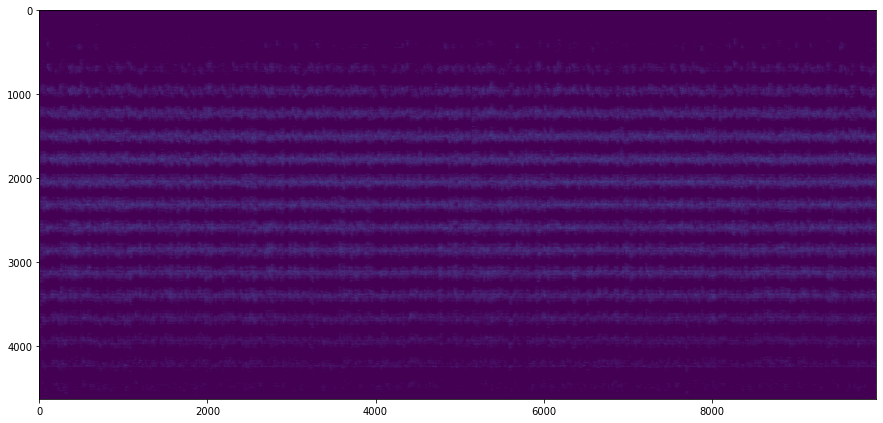

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(X.T)

### Performing logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [17]:
lr.score(X_test, y_test)

0.978399756616976

In [18]:
P_pred = lr.predict_proba(X_test)
P_pred.shape

(3287, 10)

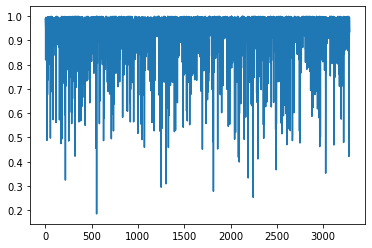

In [19]:
plt.plot(np.max(P_pred, axis=1))